# EDA for exam score prediction example

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Load data from directory

In [2]:
# 1. Setup Paths
BASE_PATH = "/rds/rds-lxu/ml_datasets/exam_score_predict"
TRAIN_PATH = os.path.join(BASE_PATH, "train.csv")
TEST_PATH = os.path.join(BASE_PATH, "test.csv")

# 2. Load Data (Using pandas to read parquet)
print("Loading data... this might take a minute depending on file size.")
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

Loading data... this might take a minute depending on file size.


### Print the train and test dimensions

In [ ]:
# 3. Basic Inspection
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")

Train Shape: (630000, 13)
Test Shape:  (270000, 12)


In [4]:
# 4. Display first few rows of training and test data
display(train_df.head())
display(test_df.head())

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


#### So, in the training set, we are given a set of candidate id, gender, and courses they pursue. We are given a series of features from study hours to exam difficulty. Finally, we want to predict the exam score of the candidates based on these features in the test set.

#### We can also print the data information using `.info()`

In [5]:
print("\nTrain Data Info:")
train_df.info()
print("\nTest Data Info:")
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 

## Inspecting missing data (Note: this happens mostly in finance)

In [6]:
print("\nMissing Values in Train Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())


Missing Values in Train Data:
id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

Missing Values in Test Data:
id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
dtype: int64


#### We can see there is no missing data in this dataset

## Univariate analysis

#### Now we get a feeling of type and shape of training data, we are going to understand one variable at a time now.

#### We split the data according to the types of features: 
* `target_col` is the target values we are going to predict
* `numerical_cols` are features that associate with numerical values
* `categorial_cols` are features associate with categories

In [7]:
target_col = "exam_score"
numerical_cols = train_df.select_dtypes(include=["int", "float"]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"\nNumerical Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")

# Verify all columns are categorized
print(len(numerical_cols) + len(categorical_cols) == train_df.shape[1])  

# Remove unecessary columns from lists
numerical_cols.remove(target_col)
numerical_cols.remove("id")
print(f"\nNumerical Columns after removing target and id: {numerical_cols}")


Numerical Columns: ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']
Categorical Columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
True

Numerical Columns after removing target and id: ['age', 'study_hours', 'class_attendance', 'sleep_hours']


### Analyze the target value

#### We first focus on the target value, things to check:
* If target is numerical values (regression):
    * How it shape looks like? Is it normal distribution?
    * If it is highly skewed, apply log transformation
* If the target is category (classification):
    * Check if the features are imbalance
    * If it is imbalance, use stratified split later

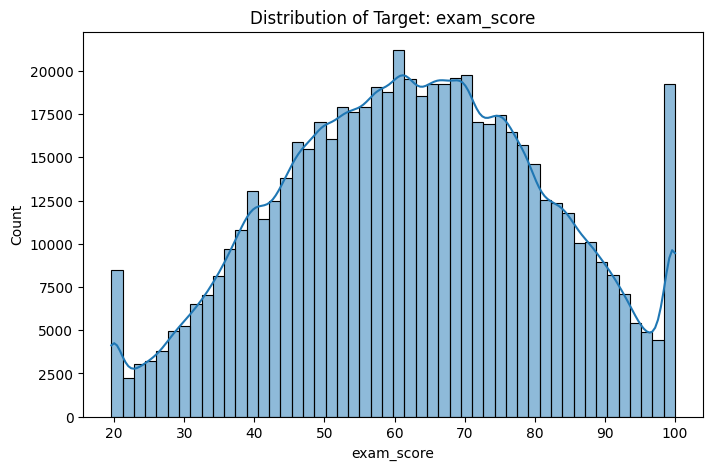

In [8]:
plt.figure(figsize=(8, 5))

# IF REGRESSION (Continuous Target)
sns.histplot(train_df[target_col], kde=True, bins=50)
plt.title(f'Distribution of Target: {target_col}')

# IF CLASSIFICATION (Categorical Target)
# sns.countplot(x=train_df[target_col])
# plt.title(f'Class Balance: {target_col}')

plt.show()

### Analyze numerical features

#### boxplots are helpful because they show outliers clearly without clutter.

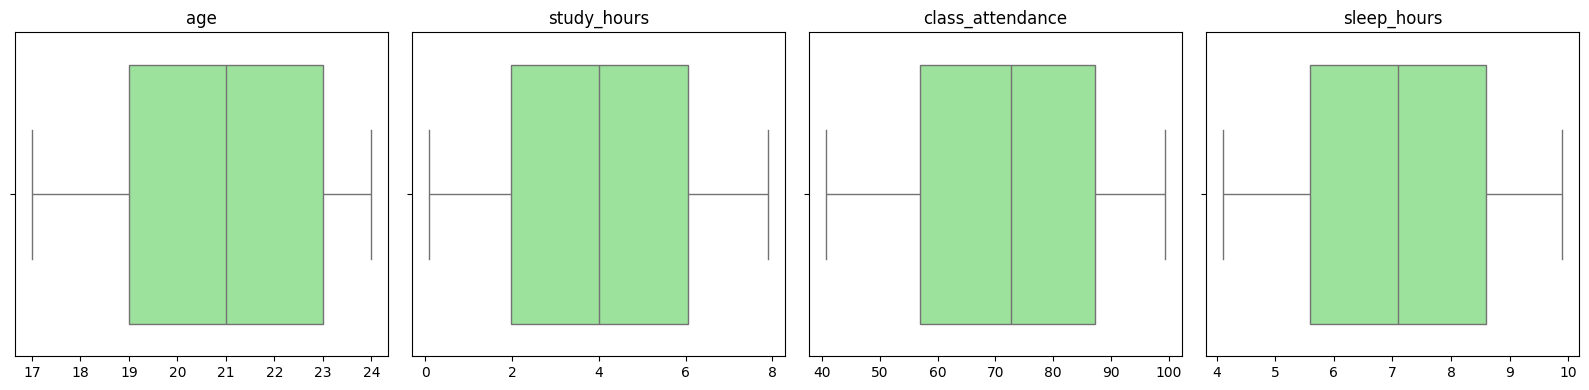

In [9]:
import math
# SETTINGS
cols_per_row = 4  # Increase this to 5 or 6 to make it even more compact
num_features = len(numerical_cols)
num_rows = math.ceil(num_features / cols_per_row)

# Create the canvas
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(16, 4 * num_rows))
axes = axes.flatten()  # Flattens the grid so we can loop over it easily

# Loop through features
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=train_df[col], ax=axes[i], color='lightgreen')
    axes[i].set_title(col)
    axes[i].set_xlabel('')  # Remove x-label to save space

# Clean up empty subplots (if features don't fill the last row perfectly)
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### In this datasets, we see that there are no outliers in this data

### Analyze Categorial Features

#### You need to be careful here. If a category has 500 unique values (High Cardinality), a plot will be unreadable.

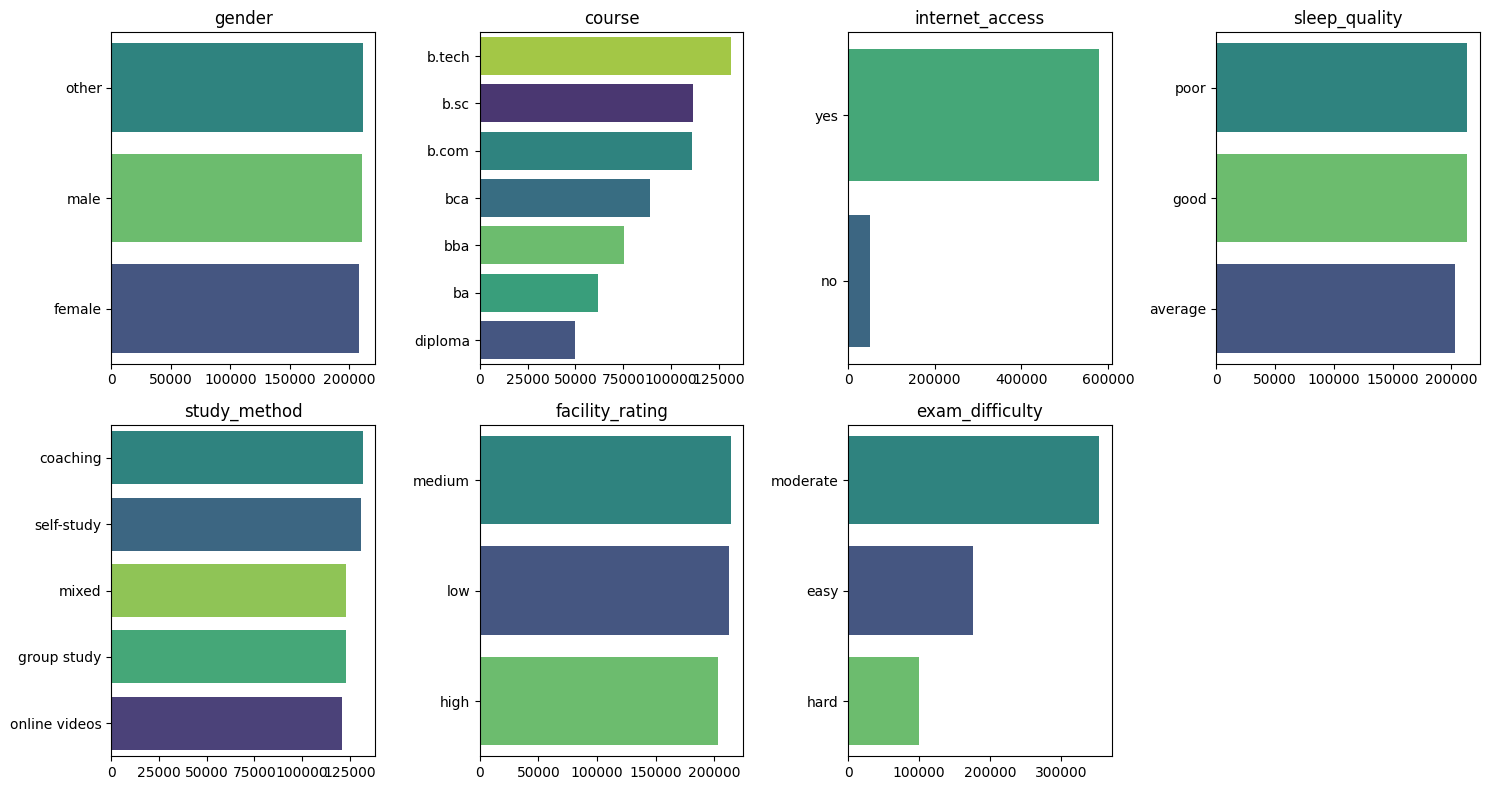

In [10]:
# Separate low and high cardinality columns
low_cardinality_cols = [col for col in categorical_cols if train_df[col].nunique() < 20]
high_cardinality_cols = [col for col in categorical_cols if train_df[col].nunique() >= 20]

# --- PART 1: PLOT LOW CARDINALITY FEATURES (The Grid) ---
if low_cardinality_cols:
    cols_per_row = 4
    num_rows = math.ceil(len(low_cardinality_cols) / cols_per_row)

    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 4 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(low_cardinality_cols):
        # FIX: Assign 'y' to 'hue' and set legend=False to suppress the warning
        sns.countplot(
            y=train_df[col], 
            hue=train_df[col], 
            ax=axes[i], 
            order=train_df[col].value_counts().index, 
            palette='viridis',
            legend=False
        )
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Clean up empty subplots
    for i in range(len(low_cardinality_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# --- PART 2: SUMMARY FOR HIGH CARDINALITY FEATURES ---
if high_cardinality_cols:
    print("\n--- High Cardinality Features (>20 unique values) ---")
    print(f"Showing top 5 most frequent values for each:")
    for col in high_cardinality_cols:
        print(f"\nFeature: {col} (Total Unique: {train_df[col].nunique()})")
        print(train_df[col].value_counts().head(5).to_string())
        print("-" * 30)

#### There are no high cardinality features in this datasets. There exists dominant categories: `internet_access`, which might have less information. There is also no typo in the categories.

## Bivariate analysis

#### Numerical features: calculating correlation matrix. If two features are highly correlated, probability need to drop one for linear models

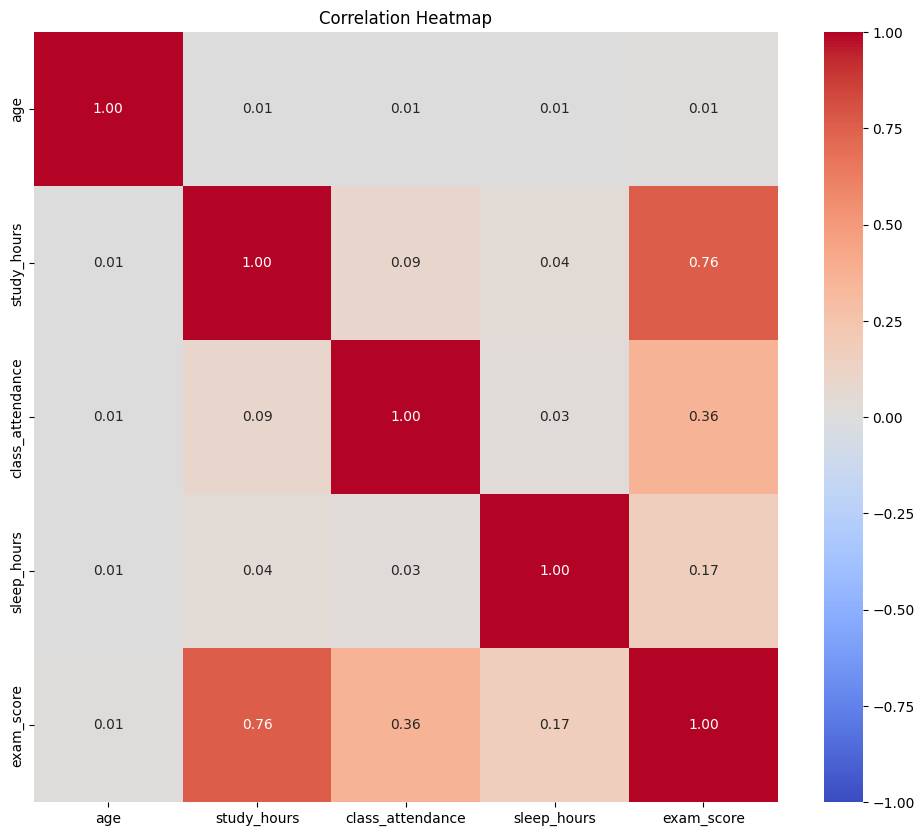

--- Top Correlations with exam_score ---
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
Name: exam_score, dtype: float64


In [15]:
# Calculate correlations
corr_matrix = train_df[numerical_cols + [target_col]].corr()

# Plot
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Hides the upper triangle (redundant)
sns.heatmap(corr_matrix, mask=None, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# Print the top correlations with the target specifically
print(f"--- Top Correlations with {target_col} ---")
print(corr_matrix[target_col].sort_values(ascending=False))

#### Numerical Features vs. Target: 
* Slope: if the fitted line is flat, that features will be useless. 
* Shape: if the shape is a "U" shape, then linear model will not be good.

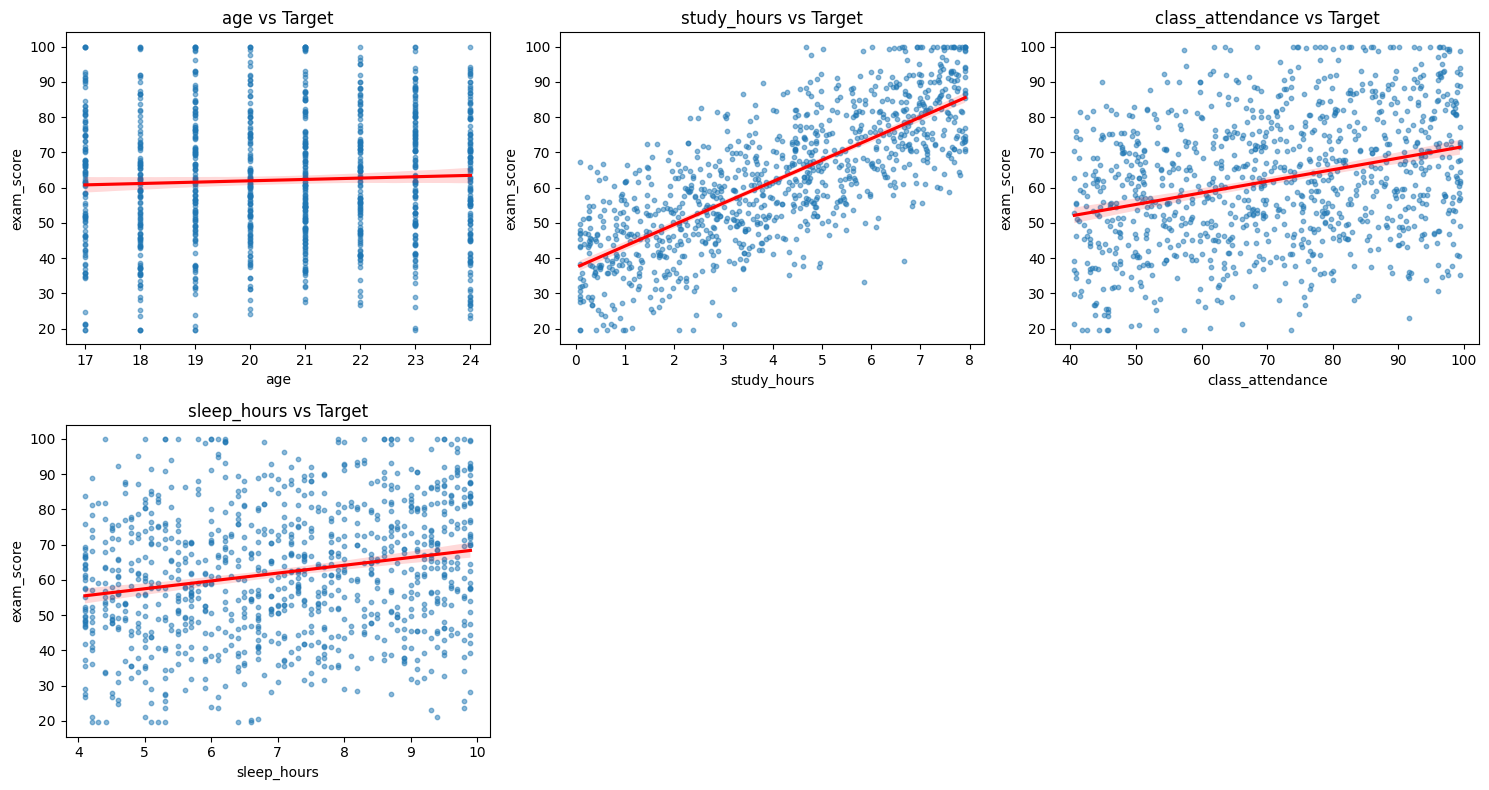

In [16]:
# SETTINGS
sample_df = train_df.sample(1000, random_state=42) # Work with a small sample for speed
cols_per_row = 3
num_rows = math.ceil(len(numerical_cols) / cols_per_row)

# Create Canvas
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    # Regplot adds a regression line so you can see the trend clearly
    sns.regplot(x=sample_df[col], y=sample_df[target_col], ax=axes[i], 
                scatter_kws={'alpha':0.5, 's':10}, line_kws={'color':'red'})
    axes[i].set_title(f'{col} vs Target')

# Clean up
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### It seems we need to drop `age`

### Categorical Features vs. Target

#### We want to know if the category affect the target, can do a boxgrid plot
* Separation: If the boxes for Category A and Category B are at different heights, that feature is Predictive (Good!).
* Overlap: If all the boxes look identical, the category doesn't change the target much.

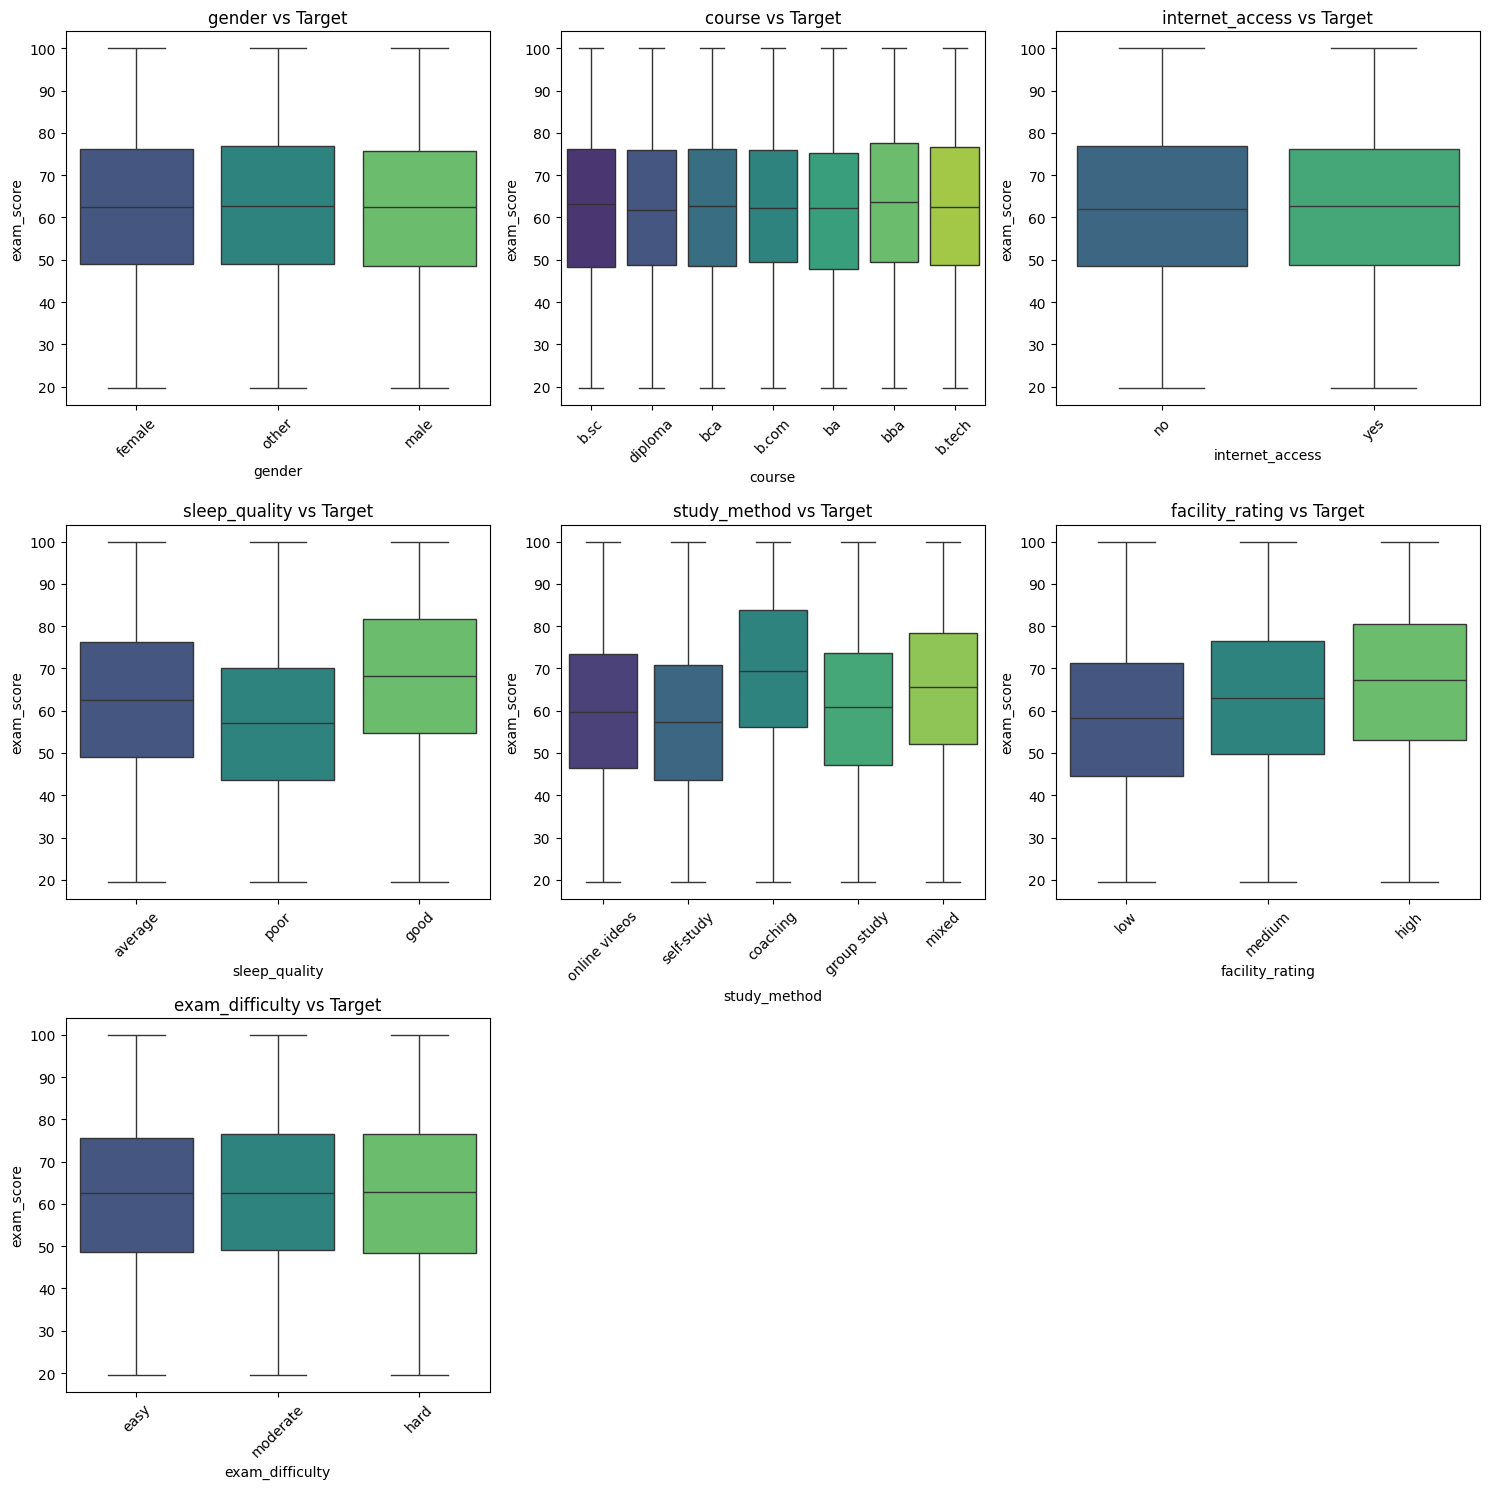

In [13]:
# Filter for low cardinality columns again (same logic as before)
low_card_cols = [col for col in categorical_cols if train_df[col].nunique() < 20]

if low_card_cols:
    cols_per_row = 3
    num_rows = math.ceil(len(low_card_cols) / cols_per_row)

    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(low_card_cols):
        # Boxplot: X=Category, Y=Target
        sns.boxplot(x=col, y=target_col, data=train_df, ax=axes[i], palette='viridis', hue=col, legend=False)
        axes[i].set_title(f'{col} vs Target')
        axes[i].tick_params(axis='x', rotation=45) # Rotate labels if they overlap

    for i in range(len(low_card_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

#### Can also try to look at the correlations between categories, using analysis of variance (ANOVA)

In [14]:
from sklearn.feature_selection import f_regression, SelectKBest

# 1. Prepare the data
# We must encode categories as numbers temporarily to run the test
# OrdinalEncoder is quick for this purpose
from sklearn.preprocessing import OrdinalEncoder

# Select only categorical columns
cat_data = train_df[categorical_cols].fillna("Missing")
enc = OrdinalEncoder()
cat_encoded = enc.fit_transform(cat_data)

# 2. Run ANOVA (f_regression)
# f_regression calculates the F-score for each feature against the target
f_scores, p_values = f_regression(cat_encoded, train_df[target_col])

# 3. Create a summary table
anova_df = pd.DataFrame({
    'Feature': categorical_cols,
    'F_Score': f_scores,
    'P_Value': p_values
})

# 4. Sort by F-Score (Highest = Most Important)
anova_df = anova_df.sort_values(by='F_Score', ascending=False)

print("--- Categorical Feature Importance (ANOVA) ---")
print(anova_df)

--- Categorical Feature Importance (ANOVA) ---
           Feature       F_Score       P_Value
4     study_method  21935.568203  0.000000e+00
3    sleep_quality   9959.249708  0.000000e+00
5  facility_rating   3718.847515  0.000000e+00
6  exam_difficulty     43.795310  3.648679e-11
0           gender     14.204311  1.640093e-04
1           course      9.453670  2.107360e-03
2  internet_access      0.126003  7.226126e-01


#### We should drop internet access definitely. We might also only use study_method, sleep_quality, facility_rating

## Model selection

### Define the metrics:
##### MSE, RMSE, MAE, $R^2$, ...

### The validation strategy:
##### Use K-fold cross validation,...

### Choose the model: Linear (Rideg/Lasso), XGBoost/LightGBM, ...